In [1]:
# default_exp data.core_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 


In [4]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.load_pd import *

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

## Normalize

In [5]:
# export
def _zeros_2_ones(o, eps=1e-8):
    nan_mask = o!=o
    o[o < eps ] = 1    
    o[nan_mask ] = 1    
    return o
    

In [6]:
o = np.arange(0,1,.1)
test_close(list(_zeros_2_ones(o,.5)),[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9])

o = np.arange(0,1,.1)[None,:]
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]])

o = torch.arange(0,1,.1)[None,:]
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]]))

o = torch.arange(0,1,.1)[None,:]
o[:,-1]= torch.tensor(float('nan'))
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]]))

o = np.arange(0,1,.1)[None,:]
o[:,-1]= np.nan
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]])

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [39]:
# export

class NormalizeTSMulti(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`.
        This is for blok seqences to not magnify the `y` part of the data.

        `mean` will set a mean instead of the mean of the x value.
        (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )
        """
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = {}, {}

    def encodes(self, o):
        for i in range(len(o)-1):
            if type(o[i]) == TensorCon and o[i].shape[-1]>0: # if tensor has shape (bs,0) than ignore
                self.m[i] = torch.mean(o[i])
                self.s[i] = torch.std(o[i]) +self.eps
            elif type(o[i]) == TensorSeqs :
                self.m[i] = torch.mean(o[i], -1, keepdim=True)
                self.s[i] = torch.std(o[i],  -1, keepdim=True) +self.eps
                self.s[i] = _zeros_2_ones(self.s[i], self.eps*10)
            elif type(o[i]) == TensorCatI:
                self.m[i], self.s[i] = 0, 1
            else:
                if o[i].shape[-1]>0:
                    print(f'NormalizeTSMulti:type {type(o[i])} on location:{i}/{len(o)} of tuple not found')
                self.m[i], self.s[i] = 0, 1
                
        # y must be scaled with m
        self.m[len(o)-1], self.s[len(o)-1] = self.m[0],self.s[0] 
        # TODO make y its own type
        if self.verbose:
            print('encodes',[a.shape for a in o],'m shape', {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        
        return TSMulti_([(o[i]-self.m[i]) / self.s[i] for i in range(len(o))])       
    
    def decodes(self, o):
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',[a.shape for a in o],  {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        return TSMulti_([(o[i]*self.s[i])+self.m[i] for i in range(len(o))])

In [8]:
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'x':[i + (i*.6)*a*-.5 for i in range(1,5)],
                   'a':[i+a for i in range(1,5)],
                   'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)],
                   'cat':[i for i in 'aabb'],                  
                  })
df

,x,a,b,cat
0,"[0.7123227176010585, 0.7729592514076216, 1.0423360024179602, 1.2727892280477044, 1.252441295442369, 1.0, 0.7475587045576311, 0.7272107719522956, 0.9576639975820398, 1.2270407485923784]","[1.9589242746631386, 1.7568024953079282, 0.8588799919401328, 0.09070257317431829, 0.1585290151921035, 1.0, 1.8414709848078965, 1.9092974268256817, 1.1411200080598671, 0.2431975046920718]",1.287409,a
1,"[1.424645435202117, 1.5459185028152431, 2.0846720048359204, 2.545578456095409, 2.504882590884738, 2.0, 1.4951174091152621, 1.454421543904591, 1.9153279951640796, 2.454081497184757]","[2.9589242746631386, 2.7568024953079284, 1.8588799919401329, 1.0907025731743183, 1.1585290151921035, 2.0, 2.8414709848078967, 2.909297426825682, 2.1411200080598674, 1.2431975046920718]",2.019129,a
2,"[2.1369681528031754, 2.3188777542228647, 3.1270080072538806, 3.8183676841431136, 3.757323886327107, 3.0, 2.242676113672893, 2.1816323158568864, 2.8729919927461194, 3.6811222457771353]","[3.9589242746631386, 3.7568024953079284, 2.8588799919401326, 2.090702573174318, 2.1585290151921033, 3.0, 3.8414709848078967, 3.909297426825682, 3.1411200080598674, 2.2431975046920716]",2.757354,b
3,"[2.849290870404234, 3.0918370056304862, 4.169344009671841, 5.091156912190818, 5.009765181769476, 4.0, 2.9902348182305243, 2.908843087809182, 3.830655990328159, 4.908162994369514]","[4.958924274663138, 4.756802495307928, 3.8588799919401326, 3.090702573174318, 3.1585290151921033, 4.0, 4.841470984807897, 4.909297426825682, 4.141120008059867, 3.2431975046920716]",4.972702,b


In [9]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, 
                  after_batch = NormalizeTSMulti(),
                  num_workers = 1)


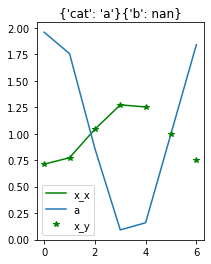

In [10]:
dl.show_batch(max_n = 1)

In [14]:
# hide
for o in dl:
    for a in o[:-1]:
        if a.shape[-1] > 0 and type(a) is not TensorCatI:
            test_close(a.mean(),0)
            test_close(a.std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti_)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()), TSMulti_)

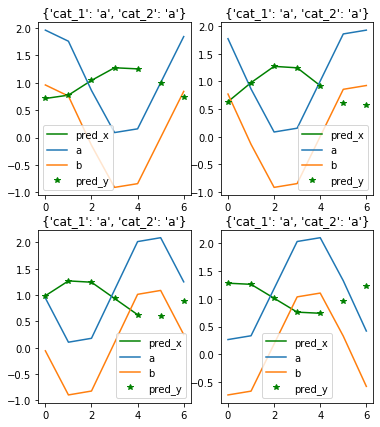

In [22]:
# hide
# basic
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[a for _ in range(1,5)],
                  'cat_1':[i for i in 'abbc'],'cat_2':[i for i in 'aabb']})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        for i in range(a.shape[0]):
            if a.shape[-1]>0 and type(a) is not TensorCatI:
                test_close(a[i].mean(),0)
                test_close(a[i].std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti_)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),TSMulti_)

dl.show_batch(max_n = 4)

# TSDataLoaders

## Utils

In [23]:
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [24]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [25]:
# export
def make_test_df(df:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the series in `df` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.

    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = {}, {}  
    for col in df:
        train[col], val[col] = [], []        
        if type(df.loc[0, col])==pd.Series or type(df.loc[0, col]) == np.ndarray:
            for row in df[col]:
                val[col].append(row.flatten()[-(horizon+lookback):])
                if keep_lookback:
                    train[col].append(row.flatten()[:-(horizon)])
                else:
                    train[col].append(row.flatten()[:-(horizon+lookback)])
        else:
            val[col]   = df[col]
            train[col] = df[col]

    return pd.DataFrame(train), pd.DataFrame(val)


In [26]:
# hide
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
train, val = make_test_df(df, 5, 2)
test_eq(train.loc[0,'x'].shape, (63,))
train.head()

,x,weather,city,cont
0,"[2.5586700980879282, 2.2077478393062306, 2.010220915755269, 1.8134488392160455, 1.6415486399447368, 1.3543125279471686, 1.3795059597190582, 1.3242257995318112, 1.22051614068189, 1.0893219197975357, 0.9132303997694484, 0.8239486420680167, 0.6303015881225273, 0.4530013033530678, 0.3381093607200172, 0.25181675187883024, 0.2595467643990081, 0.21701603873865916, 0.09625502401226665, 0.1764156963310588, 0.12665041722934495, 0.10865631528563678, 0.009560638609685763, -0.01170568417016291, -0.06271085200188575, -0.05953000231838514, -0.13263089111213464, -0.10467827129410825, 0.011398213650195119,...","[4.272916738658142, 4.037109792557596, 4.026740860663555, 4.333833734713896, 4.963996945581661, 5.8299815260138965, 6.77248503206312, 7.602497842437657, 8.153048092019496, 8.325332840977374, 8.115791322539664, 7.616226200635978, 6.986968708124239, 6.41097361644512, 6.042280492753268, 5.963846621524162, 6.166889131232516, 6.557435329977185, 6.987697965304616, 7.302576959761104, 7.387215151440319, 7.20139095951477, 6.790635305690886, 6.27106184599613, 5.792853556554922, 5.493761553646209, 5.456920348638878, 5.685890708304556, 6.10453839717605, 6.581752931234413, 6.9734061842063095, 7.1686473...",0,1.779668
1,"[0.36396074720425164, -0.0940306756754379, -0.22728676672558815, -0.484820677669395, -0.1858666734543265, -0.08548408793832314, -0.23133766514233342, -0.1310848183190015, -0.29761951331376724, -0.11839042619896056, -0.5931325356832694, -0.5368817788070305, -0.5005405064890242, -0.5041328141705489, -0.7666074924704784, -0.5410148671268054, -0.25233555547096265, -0.6259902694535947, -0.16750872310657383, -0.14810054532922948, -0.07854723565790397, -0.20019684562612602, -0.5582803090558824, -0.8597925684718375, -1.1648095975835784, -1.7228244053625374, -1.7114931320516475, -1.964028908916789,...","[0.39127597144130766, 0.23440728975005898, 0.22137232788065764, 0.4212286892693927, 0.832752277799114, 1.3765255671132508, 1.9124467627357844, 2.2782630779275315, 2.3380489820220767, 2.026124168524085, 1.3728228366043296, 0.5035717027502282, -0.38954980306316056, -1.0964811285787588, -1.4447014208759101, -1.3459676806702445, -0.8209367039949976, 0.005460272004368938, 0.9367156747382512, 1.7563596305414397, 2.284007676237018, 2.420240560988797, 2.168108418678001, 1.6259354453030623, 0.9544289192957464, 0.3284096826455972, -0.1123588545184453, -0.29894532907778715, -0.2457348008110659, -0.03...",0,1.590515
2,"[2.504787424720703, 2.099571939646569, 1.834260501047224, 1.6327807166967923, 1.4563147421236708, 1.2131792984320404, 1.1553228225463585, 0.9250936348502944, 0.7599487021028571, 0.8131616857378611, 0.6137998597616379, 0.7194050938799733, 0.7602641258535834, 0.7774886864061148, 0.7865175022359494, 0.6325003752354288, 0.5713710514517507, 0.5721887700840096, 0.4481544454732122, 0.295531277520519, 0.20013343313324125, 0.10971211894406005, -0.13336422485305072, -0.24409383962510586, -0.46058771458882863, -0.49543173306487787, -0.6734801979052186, -0.6722264152040738, -0.6879598948376453, -0.539...","[1.837539003552076, 1.9170612802562768, 1.927021152790163, 1.8818509792335811, 1.803428735876953, 1.718123275293344, 1.6532330666835255, 1.6332993863444103, 1.6767918823171697, 1.7936141460755488, 1.9837661776195463, 2.2373443854754194, 2.5358791216019965, 2.854829109702396, 3.166895880575753, 3.4457105816491054, 3.669395236631976, 3.8235174874445312, 3.9030397641487404, 3.912999636682655, 3.867829463126044, 3.7894072197694166, 3.7041017591858223, 3.6392115505760123, 3.61927787023687, 3.6627703662096254, 3.7795926299680005, 3.9697446615119842, 4.223322869367873, 4.521857605494459, 4.840807...",0,-0.549271
3,"[2.1889841061117714, 2.0319231260970083, 1.9790604533677711, 1.788553310670217, 1.7500012042533268, 1.5729463675181101, 1.4712766024181967, 1.3216133475167298, 1.2641631224670073, 1.0653854729828574, 1.1451948965359062, 1.148998354624777, 0.9591874875747503, 1.0322815111810668, 0.8670446931100955, 0.7931152579670387, 0.796

In [27]:
a = pd.DataFrame({'a':[np.arange(0,15)]*50,'b':[np.arange(0,15)]*50, 'c':[3]*50})
train, val = make_test_df(a,5,2)
test_eq(train['a'][0].max(),7)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                          a                         b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

In [28]:
# hide
train, val = make_test_df(a,5,2,True)
test_eq(train['a'][0].max(),9)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                                a                               b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

## Dataloaders

In [30]:
#export
class DfDataLoaders(DataLoaders):
    @classmethod
    @delegates(DfDataLoader.__init__)
    def from_df(cls, dataset:pd.DataFrame, y_name:str, horizon:int, valid_pct=1.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create an list of time series.
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        lookback = ifnone(lookback, horizon * 4)
        device = ifnone(device, default_device())
        if incl_test:
            dataset, test = make_test_df(dataset, horizon, lookback, keep_lookback = True)
        train, valid = make_test_df(dataset, horizon + int(valid_pct*horizon), lookback , keep_lookback = True)
        if norm and 'after_batch' not in kwargs:
            make_ones = kwargs.pop('make_ones', True)
            kwargs.update({'after_batch':L(NormalizeTSMulti(make_ones=make_ones))})
        db = DataLoaders(*[DfDataLoader(ds, y_name, horizon=horizon, lookback=lookback, step=step, device=device, norm = False, **kwargs)
                           for ds in [train,valid]], path=path, device=device)
        if incl_test:
            db.test = DfDataLoader(test, y_name, horizon=horizon, lookback=lookback, step=step, name='test', device=device, **kwargs)

            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")

        return db

In [31]:
# hide
# device `cpu`
horizon,lookback = 2,5
t = np.arange(-5,25)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,100)],'a':[i+a for i in range(1,100)]})


In [32]:
# hide
data = DfDataLoaders.from_df(df, 'pred', horizon = horizon, lookback=lookback, step=5, device = torch.device('cpu'))
test_eq(data.valid.dataset.iloc[0,0].shape[-1],data.valid.dataset.iloc[0,1].shape[-1])
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], torch.device('cpu'))
test_eq([o[0].device for o in data.test][0], torch.device('cpu'))

Train:396; Valid: 99; Test 99


In [33]:
# hide
# default device

data = DfDataLoaders.from_df(df,'pred', horizon = horizon, lookback=lookback, step=5)
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], default_device())
test_eq([o[0].device for o in data.test][0], default_device())

Train:396; Valid: 99; Test 99


In [34]:
# hide
dbunch = DfDataLoaders.from_df(df,'pred',horizon=horizon, lookback = lookback, incl_test=False)
test_eq(hasattr(dbunch,'test'),False)

Train:1881; Valid: 396


In [35]:
show_doc(DfDataLoaders.from_df, name='DfDataLoaders.from_df')

<h4 id="DfDataLoaders.from_df" class="doc_header"><code>DfDataLoaders.from_df</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>DfDataLoaders.from_df</code>(**`dataset`**:`DataFrame`, **`y_name`**:`str`, **`horizon`**:`int`, **`valid_pct`**=*`1.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`min_seq_len`**=*`None`*, **`max_std`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series.
The `DataLoader` for the test set will be save as an attribute under `test`

In [36]:
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
df['city'] = df['city'].astype(float)
df.head(3)

,x,weather,city,cont
0,"[[1.9066582215799321, 1.7931066187469158, 1.5429388294653417, 1.4049544741784248, 1.2603497122338267, 1.255752038006458, 1.0658563272715853, 1.0672961276652273, 0.9719389293657945, 1.0210802135734103, 0.9142902598192291, 0.9491804405061881, 0.9573426168326674, 0.8399981663340349, 0.9193038203495045, 0.9413538325634113, 0.8578959604088741, 0.9094682163189101, 0.7495355757580376, 0.733479508817479, 0.6382287961939579, 0.5781399977790408, 0.6231793945081326, 0.6743169554063383, 0.5570436219547642, 0.5464791044833727, 0.5137677974881563, 0.5428930958628394, 0.44195286384941446, 0.5697758187684...","[[2.8370107329224776, 2.7791292719101177, 2.624849697485922, 2.4020041460017962, 2.150202995560144, 1.912446003906121, 1.7264318357938104, 1.6176033593803298, 1.5954261607438043, 1.6534883454161773, 1.7729952922703118, 1.9283998778906457, 2.09348154916177, 2.246265735642856, 2.3717063519173807, 2.4618545647667354, 2.514049210061827, 2.528236936668254, 2.5046944652323977, 2.4431450751078976, 2.3436421174291007, 2.208846756325117, 2.046707825014644, 1.872271408914101, 1.7075120784643099, 1.5786503867807309, 1.5112334572789354, 1.5240559110860152, 1.623529642670075, 1.8001890659529605, 2.0285...",0.0,-1.317519
1,"[[2.0880860258710965, 1.9289571655120767, 1.7908781583681463, 1.7274605769514182, 1.6045304398759932, 1.5935113590127596, 1.528189201021818, 1.4101811548008951, 1.2867059686919748, 1.207947668088053, 1.094292658201136, 1.0051294869234548, 0.9531903585153818, 0.936513724342802, 0.8657459901208043, 0.8349181477718745, 0.8449036544293, 0.8210146720805496, 0.7268180352907981, 0.6674991711584051, 0.5907842413564819, 0.3821086170190952, 0.27711498752604863, 0.14472320907919123, 0.022568502423749425, -0.05940862028371216, -0.14959580035727094, -0.1810510267459594, -0.143350169387519, -0.151119870...","[[3.735743034487696, 3.587121397451233, 3.7266420564270026, 4.111899510634852, 4.599560848119744, 4.988281795256664, 5.082692680427596, 4.758790640047737, 4.01022149176445, 2.9603530976289143, 1.8351499543894998, 0.9036470725232384, 0.4027523880558048, 0.4681755568524806, 1.0919181224850936, 2.1193101920644466, 3.2872051453920843, 4.292989780762125, 4.875063009231145, 4.882048473487788, 4.311243674915335, 3.3057191868430373, 2.111438035325837, 1.0072437257106814, 0.2281944328212071, -0.09571750740345464, 0.031663021175662553, 0.4836370840998747, 1.0567714530440493, 1.5372363098053283, 1.76...",0.0,0.929798
2,"[[1.2479037825080825, 1.3722559925477205, 1.2873619532005816, 1.2834171982907898, 1.370370689182064, 1.3649038383303396, 1.4130734209249807, 1.312979851043882, 1.345713137961592, 1.3613767134137478, 1.3660417139321503, 1.2662234990851364, 1.2430261918483492, 1.187268405661568, 1.1382163545890065, 1.071450223105094, 1.0005627811604605, 1.0322734265420983, 0.8769377287194858, 0.8518808826997502, 0.6877494817798582, 0.7398604656990889, 0.6459640663230586, 0.6104674296414639, 0.5630528148252684, 0.510049072617415, 0.5088201506908177, 0.3329905850292121, 0.3680487186579417, 0.3766169420815252, ...","[[6.300901883716052, 6.238812080030318, 6.229434157835098, 6.261831796601978, 6.319426654808298, 6.382237366823431, 6.42957813705785, 6.442852471281398, 6.408064736215878, 6.317710347361643, 6.171789304718697, 5.977806192786679, 5.749756644843792, 5.506237155120166, 5.267933519205401, 5.054827102730043, 4.8834962472167955, 4.764877273194062, 4.702787469508323, 4.693409547313081, 4.725807186079983, 4.7834020442863014, 4.846212756301425, 4.893553526535836, 4.906827860759406, 4.872040125693888, 4.781685736839656, 4.6357646941967205, 4.44178158226469, 4.213732034321799, 3.970212544598207, 3.73...",0.0,-0.253243


Train:130; Valid: 60; Test 10


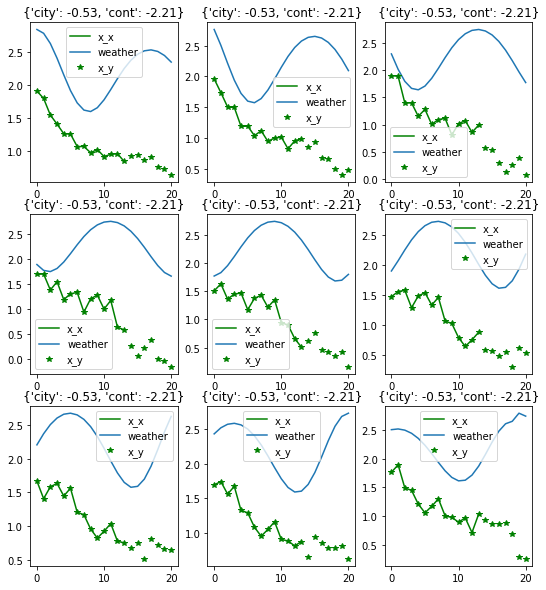

In [37]:
dbunch =  DfDataLoaders.from_df(df, 'x', horizon = 7, lookback=14, step=2, bs=32)
dbunch.train.show_batch(max_n=9)

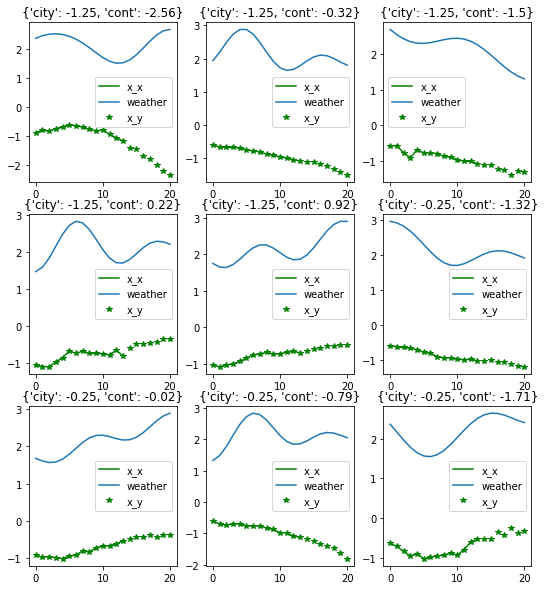

In [38]:
dbunch.test.show_batch(max_n=9)

# M5 Example

In [66]:
path = Path('../data/m5')
path.ls()

(#5) [Path('../data/m5/sales_train_validation.csv'),Path('../data/m5/sample_submission.csv'),Path('../data/m5/calendar.csv'),Path('../data/m5/m5-forecasting-accuracy.zip'),Path('../data/m5/sell_prices.csv')]

In [109]:
df_sales = pd.read_csv(path / 'sales_train_validation.csv',).iloc[:1000,:]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [110]:
def _to_series(df):
    r = L()
    for i in range(df.shape[0]):
        r.append(pd.Series(df.iloc[i,6:]))
    return r

def to_contained_series(df):    
    data={k:v for k,v in dict(df).items() if 'd_' not in k}
    data['sales'] = _to_series(df)
    df = pd.DataFrame(data=data)
    return df
df_sales = to_contained_series(df_sales)
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0, 2, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 3, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 1, 3, ...)"
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
...,...,...,...,...,...,...,...
995,HOUSEHOLD_1_440_CA_1_validation,HOUSEHOLD_1_440,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,"(0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 1, 3, 2, 2, 1, 0, 2, 1, 2, 0, 5, 2, 0, 0, 1, 7, 0, 0, 0, 0, 0, 0, 0, 4, 3, 1, 1, 1, 4, 2, 2, 4, 3, 1, 1, 4, 5, 11, 2, 2, 0, 3, 2, 7, 7, 2, 3, 0, 0, 5, 7, 9, 5, 3, 4, 4, 0, 5, 3, 4, 3, 1, 2, 3, 3, 9, 4, 3, 2, 1, 5, 0, 8, 3, 3, 3, 3, 5, 3, 4, 3, 3, 0, 2, 4, 3, 7, ...)"
996,HOUSEHOLD_1_441_CA_1_validation,HOUSEHOLD_1_441,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
997,HOUSEHOLD_1_442_CA_1_validation,HOUSEHOLD_1_442,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
998,HOUSEHOLD_1_443_CA_1_validation,HOUSEHOLD_1_443,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2, 2, 3, 6, 0, 0, 0, 0, 1, 0, 0, 0, 2, 4, 2, 1, 2, 8, 0, 0, 0, 0, 0, 0, 0, 8, 3, 5, 3, 2, 1, 2, 5, 2, 1, 2, 7, 3, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, ...)"


In [111]:
dbunch =  DfDataLoaders.from_df(df_sales, 'sales', horizon = 28, lookback=28*3, step=2)
dbunch.train.show_batch(max_n=9)

Exception: <class 'str'>

In [107]:
df_prices = pd.read_csv(path / 'sell_prices.csv')
df_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [106]:
df_cal = pd.read_csv(path / 'calendar.csv')
df_cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [40]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
